In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import SobolPlot

from ema_workbench import (RealParameter, ema_logging, load_results)
from ema_workbench.em_framework import (get_SALib_problem)

from SALib.analyze import sobol

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

# Sobol Analysis
This contains a global variance sensitivity analysis of the initial SIR-SEIR model as provided in the assignment. It serves to indicate the input variables of importance by highlighting how sensitive the different outputs of interest are to the input uncertainties using the Sobol Indices method.

The script first loads an existing data set (with the number of runs being a multiple of 12 and numbering at least 1000 * (k+1) where k=nr_uncertainties).

As the Sobol analysis cannot handle categorical inputs, this analysis uses data generated by a customized version of the model with the CategoricalParameter for the SEIR/SIR switch replaced with a RealParameter and a model-internal logic operation to round the RealParameter (range 0.0-1.0) to a categorical 0 or 1. This does not change model functionality.

The script calculates direct (S1), pairwise (S2) and total (ST) Sobol indices for every input uncertainty and the outcome of interest, and returns them in charts together with the associated confidences. A visualization combines all the information to highlight individual and joint sensitivities.

Code largely taken from EMA Workbench online documentation and examples.

In [2]:
uncertainties = [RealParameter('Average incubation time', 0.5, 14),
                 RealParameter('Average infectious period', 7, 21),
                 RealParameter('Basic reproduction number', 0.5, 5),
                 RealParameter('Case fatality rate', 0.01, 0.5),
                 RealParameter('SwitchInput', 0,1)]

In [3]:
results = load_results(r'./data/real_LHS_12000.tar.gz')

[MainProcess/INFO] results loaded succesfully from /Users/eebart/Coursework/EPA1361/Notebooks/EPA1361_20162017_PoliciesForInfectiousDisease/data/real_LHS_12000.tar.gz


In [4]:
#last element of every model run for outcome of interest, with some fancy mutation of the array
experiments, outcomes = results
y = outcomes['Deceased population']
ytruncated = y.T[y.shape[1]-1]
ytruncated.shape

(12000,)

In [5]:
problem = get_SALib_problem(uncertainties)

sobol_indices = sobol.analyze(problem, ytruncated)
sobol_stats = {key:sobol_indices[key] for key in ['ST', 'ST_conf', 'S1', 'S1_conf']}
sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])
sobol_stats.sort_values(by='S1', ascending=False)

,S1,S1_conf,ST,ST_conf
SwitchInput,0.057035,0.096669,0.995600,0.063624
Case fatality rate,0.046507,0.100021,0.989935,0.064870
Basic reproduction number,0.043061,0.096882,1.016037,0.072570
Average infectious period,0.017251,0.083649,0.970711,0.066724
Average incubation time,-0.016654,0.084050,0.985586,0.064104


In [6]:
pd.DataFrame(sobol_indices['S2'], index=problem['names'], columns=problem['names'])

,Average incubation time,Average infectious period,Basic reproduction number,Case fatality rate,SwitchInput
Average incubation time,NaN,0.031085,-0.000463,0.025426,-0.007038
Average infectious period,NaN,NaN,-0.015284,-0.017867,-0.034896
Basic reproduction number,NaN,NaN,NaN,-0.058313,-0.130668
Case fatality rate,NaN,NaN,NaN,NaN,-0.051174
SwitchInput,NaN,NaN,NaN,NaN,NaN


In [7]:
pd.DataFrame(sobol_indices['S2_conf'], index=problem['names'], columns=problem['names'])

,Average incubation time,Average infectious period,Basic reproduction number,Case fatality rate,SwitchInput
Average incubation time,NaN,0.120047,0.133408,0.134950,0.122829
Average infectious period,NaN,NaN,0.125902,0.133272,0.124168
Basic reproduction number,NaN,NaN,NaN,0.152295,0.137618
Case fatality rate,NaN,NaN,NaN,NaN,0.132420
SwitchInput,NaN,NaN,NaN,NaN,NaN


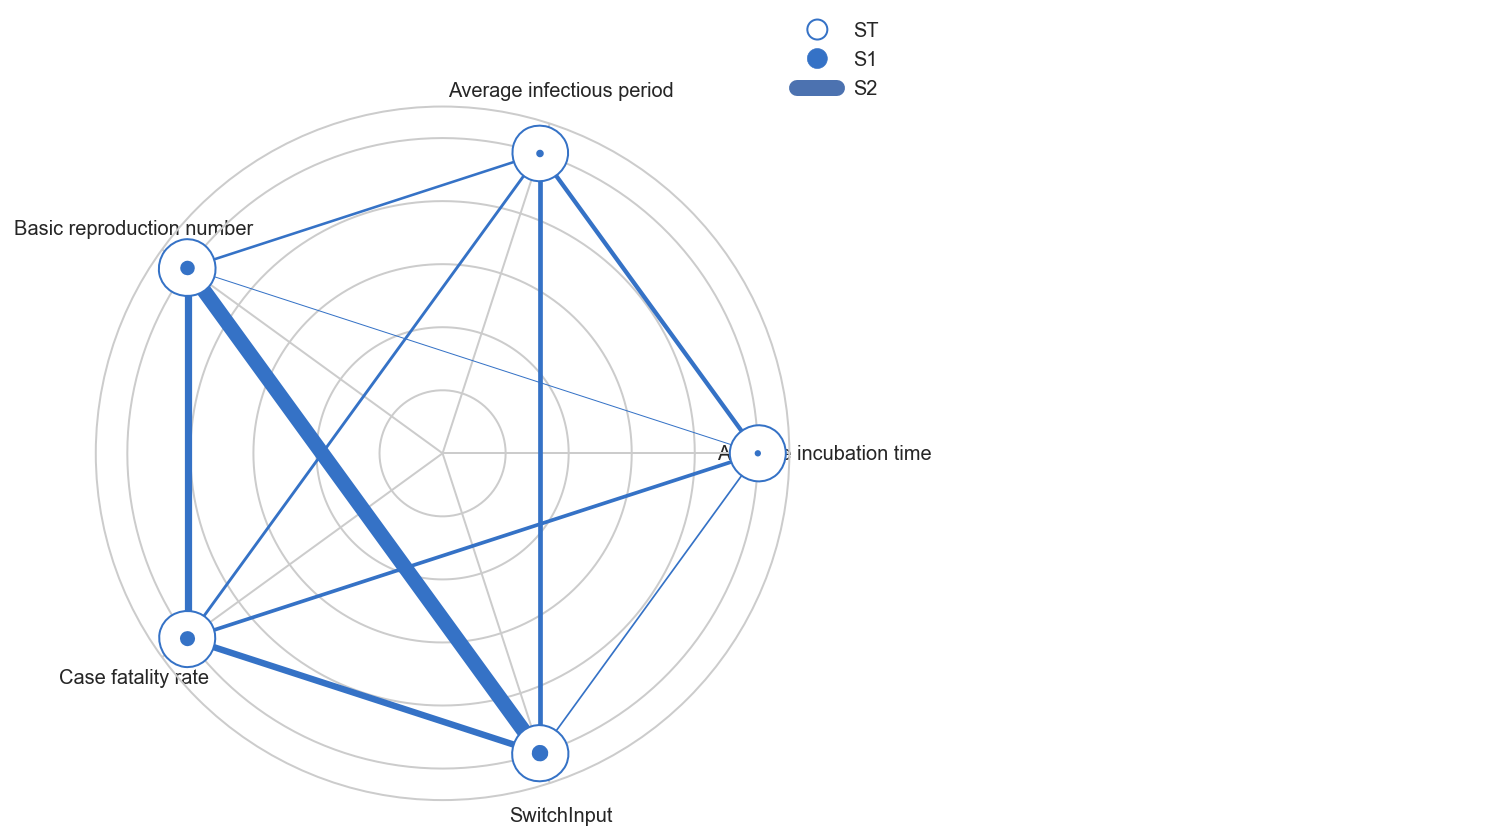

In [8]:
sns.set_style('whitegrid')
fig = SobolPlot.plot_sobol_indices(problem, sobol_indices, criterion='ST', threshold=0.005)
plt.show()